In [1]:
from keras.applications import *
from keras.preprocessing.image import *
import h5py
import math
import gc
from keras.models import *
from keras.layers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os,sys
import shutil
from keras.optimizers import *
from keras.callbacks import *
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.
D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## LabelSmooth 
相关论文[Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567.pdf)

In [ ]:
def getlabelDistribution(type=0):
    dictdir = {}
    rootdir = 'adacolorcrop'#训练数据目录
    for parent1, dirnames, filenames in os.walk(rootdir):
        for dir in dirnames:
            dictdir[int(dir)] = 0
    # type = 1 用均匀分布
    if type == 1:
        for item in dictdir:
            dictdir[item] = 1 / float(len(dictdir))
    # type = 0 用训练数据集中标签实际分布
    else:
        allcount = 0
        for dir in dictdir:
            count = 0
            for parent, dirnames, filenames in os.walk(rootdir + str(dir) + '/'):
                for filename in filenames:
                    count = count + 1
                    allcount = allcount + 1
            dictdir[dir] = count

        for dir in dictdir:
            dictdir[dir] = float(dictdir[dir]) / allcount

    return dictdir

def labelSmooth(y_train, type=0, weight = 0.01):
    labeldistribution = getlabelDistribution(type)
    df_y_train = pd.DataFrame(y_train)
    for col in df_y_train.columns:
        f = lambda x: x * (1 - weight) + weight * labeldistribution[col]
        df_y_train[col] = df_y_train[col].apply(f)
    return np.array(df_y_train)

fold_y_train = labelSmooth(fold_y_train)

## Center loss

In [ ]:
def get_center_loss(features, labels, alpha, num_classes):
    # alpha:中心的更新比例
    # 获取特征长度
    len_features = features.get_shape()[1]
    # 建立一个变量，存储每一类的中心，不训练9
    centers = tf.get_variable('centers', [num_classes, len_features], dtype=tf.float32,
        initializer=tf.constant_initializer(0), trainable=False)
    # 将特征reshape成一维
    labels = tf.reshape(labels, [-1])
 
    # 获取当前batch每个样本对应的中心
    centers_batch = tf.gather(centers, labels)
    # 计算center loss的数值
    loss = tf.nn.l2_loss(features - centers_batch)
 
    # 以下为更新中心的步骤
    diff = centers_batch - features
 
    # 获取一个batch中同一样本出现的次数，这里需要理解论文中的更新公式
    unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
    appear_times = tf.gather(unique_count, unique_idx)
    appear_times = tf.reshape(appear_times, [-1, 1])
 
    diff = diff / tf.cast((1 + appear_times), tf.float32)
    diff = alpha * diff
    # 更新中心
    centers = tf.scatter_sub(centers, labels, diff)
 
    return loss, centers

## LabelShuffling(海康威视2016ImageNet)和Verification loss
相关论文[A Discriminatively Learned CNN Embedding for Person Re-identification](https://arxiv.org/pdf/1611.05666.pdf)

In [2]:
class Mygen:
    labels=[]
    
    def verification_list(self,path,rate):
        gen = ImageDataGenerator()
        classes = list(range(100))
        for i, c in zip(range(100), classes):
            classes[i] = str(c)
        train_generator = gen.flow_from_directory(path, shuffle=False, classes=classes)
        tmp=pd.DataFrame(train_generator.filenames,columns=['name'])
        tmp['label']=tmp['name'].str.split('\\').apply(lambda x:x[0]).astype('int32')
        tmp['name']=tmp['name'].str.split('\\').apply(lambda x:x[1])
        count=tmp['label'].value_counts().to_dict()
        tmp['idx']=tmp.index
        tmp=shuffle(tmp)#############
        tmp['id']=tmp.groupby('label').cumcount()
        tmp=tmp[['id','label','idx','name']]

        lst_same=pd.DataFrame(columns=['id','label']).astype('int32')
        lst_same1=pd.DataFrame(columns=['id','label']).astype('int32')
        for i in range(100):
            cnt=count[i]
            tmp_lst=pd.DataFrame(columns=['id'])
            tmp_lst['id']=shuffle(np.array(range(math.ceil(cnt*rate))))%cnt
            tmp_lst['label']=i
            lst_same=lst_same.append(tmp_lst,ignore_index=True)

            tmp_lst=pd.DataFrame(columns=['id'])
            tmp_lst['id']=shuffle(np.array(range(math.ceil(cnt*rate))))%cnt
            tmp_lst['label']=i
            lst_same1=lst_same1.append(tmp_lst,ignore_index=True)

        lst_same=pd.merge(lst_same,tmp,how='left',on=['id','label'])
        lst_same1=pd.merge(lst_same1,tmp,how='left',on=['id','label'])
        lst_same.drop(['id'],axis=1,inplace=True)
        lst_same1.drop(['id'],axis=1,inplace=True)
        lst_same['label_']=lst_same1['label']
        lst_same['idx_']=lst_same1['idx']
        lst_same['name_']=lst_same1['name']

        lst_diff=pd.DataFrame(columns=['id','label']).astype('int32')
        lst_diff1=pd.DataFrame(columns=['idx']).astype('int32')
        for i in range(100):
            cnt=count[i]
            tmp_lst=pd.DataFrame(columns=['id'])
            tmp_lst['id']=shuffle(np.array(range(cnt)))
            tmp_lst['label']=i
            lst_diff=lst_diff.append(tmp_lst,ignore_index=True)

            tmp_lst=pd.DataFrame(columns=['idx'])
            tmp_lst['idx']=shuffle(tmp.loc[tmp['label']!=i,'idx'].values)[:count[i]]
            lst_diff1=lst_diff1.append(tmp_lst,ignore_index=True)

        lst_diff=pd.merge(lst_diff,tmp,how='left',on=['id','label'])
        lst_diff1=pd.merge(lst_diff1,tmp,how='left',on=['idx'])
        lst_diff.drop(['id'],axis=1,inplace=True)
        lst_diff1.drop(['id'],axis=1,inplace=True)
        lst_diff['label_']=lst_diff1['label']
        lst_diff['idx_']=lst_diff1['idx']
        lst_diff['name_']=lst_diff1['name']

        lst=lst_same.append(lst_diff,ignore_index=True)
        lst=shuffle(lst)
        return lst

    def label_shuffling(self,path):
        gen = ImageDataGenerator()
        classes = list(range(100))
        for i, c in zip(range(100), classes):
            classes[i] = str(c)
        train_generator = gen.flow_from_directory(path, shuffle=False, classes=classes)
        tmp=pd.DataFrame(train_generator.filenames,columns=['name'])
        #首先对原始的图像列表，按照标签顺序进行排序；
        tmp['label']=tmp['name'].str.split('\\').apply(lambda x:x[0]).astype('int32')
        tmp['name']=tmp['name'].str.split('\\').apply(lambda x:x[1])
        #然后计算每个类别的样本数量，并得到样本最多的那个类别的样本数
        count=tmp['label'].value_counts().to_dict()
        tmp['id']=tmp.groupby('label').cumcount()
        tmp=tmp[['id','name','label']]
        tmp['idx']=tmp.index
#         tmp=shuffle(tmp)
        max_count=max(count.values())
        #根据这个最多的样本数，对每类随机都产生一个随机排列的列表；
        #然后用每个类别的列表中的数对各自类别的样本数求余，得到一个索引值，从该类的图像中提取图像，生成该类的图像随机列表；
        #然后把所有类别的随机列表连在一起，做个Random Shuffling，得到最后的图像列表，用这个列表进行训练
        lst=pd.DataFrame(columns=['id','label']).astype('int32')
        for i in range(100):
            tmp_lst=pd.DataFrame(columns=['id'])
            tmp_lst['id']=shuffle(np.array(range(max_count)))%count[i]
            tmp_lst['label']=i
            lst=lst.append(tmp_lst,ignore_index=True)
            
        lst=pd.merge(lst,tmp,how='left',on=['id','label'])
        lst.drop(['id'],axis=1,inplace=True)
        lst=shuffle(lst).reset_index(drop=True)
        return lst

    def myflow(self,path,batch_size,preprocess,image_size):
        while 1:
            lst=self.label_shuffling(path)
            cnt = 0
            X =[]
            Y =[]
            for i in lst.index:
                label=lst.loc[i,'label']
                name=lst.loc[i,'name']
                x = load_img(path+'\\'+str(label)+'\\'+name).resize(image_size)
                x = img_to_array(x)
                x= preprocess(x)
                X.append(x)
                Y.append(label)
                self.labels.append(label)
                cnt += 1
                if cnt==batch_size:
                    cnt = 0
                    yield (np.array(X), np.array(Y))
                    X = []
                    Y = []

In [3]:
##尝试verification loss
nb_epoch = 100
np.random.seed(1000)
rootdir='model\\'
X_train = []
X_tmp=[]
X_val = []
X_test = []

for filename in ['test_Xception.h5']: 
    with h5py.File(rootdir+'tmp\\'+filename, 'r') as h:
        X_test.append(np.array(h['test']))
X_test = np.concatenate(X_test, axis=1)

path='bddogtrain\\data\\'
rate=1
X_train1=[]
y_train1=[]
X_train2=[]
y_train2=[]
mygen=Mygen()
lst=mygen.verification_list(path,rate)
with h5py.File(rootdir+'data_Xception.h5', 'r') as h:
        X_tmp=np.array(h['train'])
        y_tmp = np.array(h['label'])
        y_tmp = np.eye(100)[y_tmp] 
        
for i in lst.index:
    idx=lst.loc[i,'idx']
    X_train1.append(X_tmp[idx])
    y_train1.append(y_tmp[idx])
    idx=lst.loc[i,'idx_']
    X_train2.append(X_tmp[idx])
    y_train2.append(y_tmp[idx])
del X_tmp,y_tmp
gc.collect()
X_train1=np.array(X_train1)
y_train1=np.array(y_train1)
X_train2=np.array(X_train2)
y_train2=np.array(y_train2)
print(X_train1.shape,y_train1.shape,X_train2.shape,y_train2.shape)

y_train3=np.eye(2)[(y_train1.argmax(axis=1)!=y_train2.argmax(axis=1)).astype('int32')]

input1 = Input(X_train1.shape[1:])
x1 = Dropout(0.5)(input1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dropout(0.5)(x1)
out1 = Dense(100, activation='softmax')(x1)

input2 = Input(X_train2.shape[1:])
x2 = Dropout(0.5)(input2)
x2 = Dense(256, activation='relu')(x2)
x2 = Dropout(0.5)(x2)
out2 = Dense(100, activation='softmax')(x2)

x3 = Lambda(lambda x: (x[0] - x[1])**2)([input1, input2])
x3=Reshape((1,1,-1))(x3)
x3=Dropout(0.5)(x3)
x3=Conv2D(2,(1,1),activation='softmax')(x3)
out3=Reshape((-1,))(x3)

model = Model([input1, input2], [out1, out2, out3])
model_1= Model(input1, out1)
model_2= Model(input2, out2)

model.compile(optimizer='adadelta',
              loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
              loss_weights=[0.5,0.5,1],
              metrics=['accuracy'])

model.fit([X_train1,X_train2], [y_train1,y_train2,y_train3], batch_size=32, epochs=21)

Found 37306 images belonging to 100 classes.
(74612, 2048) (74612, 100) (74612, 2048) (74612, 100)
Epoch 1/21
74612/74612 [==============================] - 33s - loss: 1.9483 - dense_2_loss: 1.4237 - dense_4_loss: 1.4236 - reshape_2_loss: 0.5246 - dense_2_acc: 0.6331 - dense_4_acc: 0.6350 - reshape_2_acc: 0.7614    
Epoch 2/21
74612/74612 [==============================] - 29s - loss: 1.2698 - dense_2_loss: 0.8784 - dense_4_loss: 0.8629 - reshape_2_loss: 0.3992 - dense_2_acc: 0.7371 - dense_4_acc: 0.7414 - reshape_2_acc: 0.8578    
Epoch 3/21
74612/74612 [==============================] - 29s - loss: 1.1405 - dense_2_loss: 0.7957 - dense_4_loss: 0.7784 - reshape_2_loss: 0.3534 - dense_2_acc: 0.7585 - dense_4_acc: 0.7628 - reshape_2_acc: 0.8677    
Epoch 4/21
74612/74612 [==============================] - 29s - loss: 1.0755 - dense_2_loss: 0.7552 - dense_4_loss: 0.7357 - reshape_2_loss: 0.3300 - dense_2_acc: 0.7678 - dense_4_acc: 0.7752 - reshape_2_acc: 0.8729    
Epoch 5/21
74612/7461

In [7]:
y_pred = model_1.predict(X_test, verbose=1)
y_pred=np.argmax(y_pred,axis=1)

10560/10593 [============================>.] - ETA: 0s

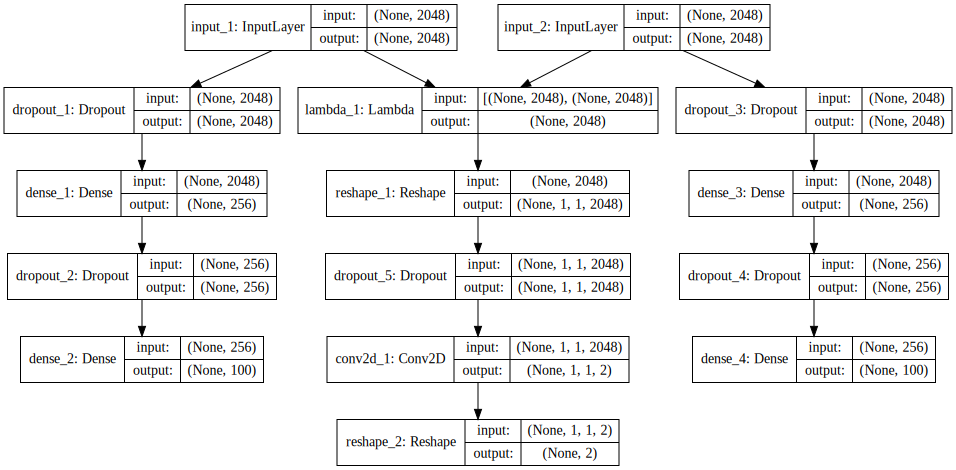

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))